In [1]:
from sys import path as sp
from pathlib import Path
from os import path

# Make scripts directory importable
sp.append(path.join((Path.cwd()).parent,"scripts"))

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from filepaths import paths
from visualisers import plot_history, plot_activity_v2, plot_axis, plot_features, plot_full_v2
from dataloader import unlink_DStore, load_to_df, get_m_features, extract_features, get_real_testdata, get_training_files

# Read Files & Set Column Names

In [3]:
# Self Training Data
trainfiles = get_training_files()
testfiles = get_real_testdata()

train_cols = ['Activity_code', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']
test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

targetfiles = testfiles
cols = test_cols

targetfiles = unlink_DStore(targetfiles)

targetfiles[1]

PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/WalkStandRun.txt')

In [4]:
df = load_to_df(targetfiles[1:], cols)
df['time']=[i+1 for i in range(df.shape[0])]
df['gz'] = df['gz'].str.slice(start=0, stop=-1)
df['gz'] = df['gz'].astype('int')
df

,ax,ay,az,gx,gy,gz,time
0,117,173,161,126,127,127,1
1,115,171,160,126,127,126,2
2,115,171,161,129,128,125,3
3,116,174,161,132,131,124,4
4,117,175,160,127,129,125,5
...,...,...,...,...,...,...,...
2671,84,107,145,144,105,101,2672
2672,84,107,145,144,105,101,2673
2673,85,107,148,142,112,105,2674
2674,85,107,148,142,112,105,2675


# Feature Extraction

In [5]:
df_copy = df.copy()
timestep = 20

/Users/anderson/Desktop/github/capstoneml/scripts/dataloader.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf["a"] = np.linalg.norm(
/Users/anderson/Desktop/github/capstoneml/scripts/dataloader.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf["g"] = np.linalg.norm(
/Users/anderson/Desktop/github/capstoneml/scripts/dataloader.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

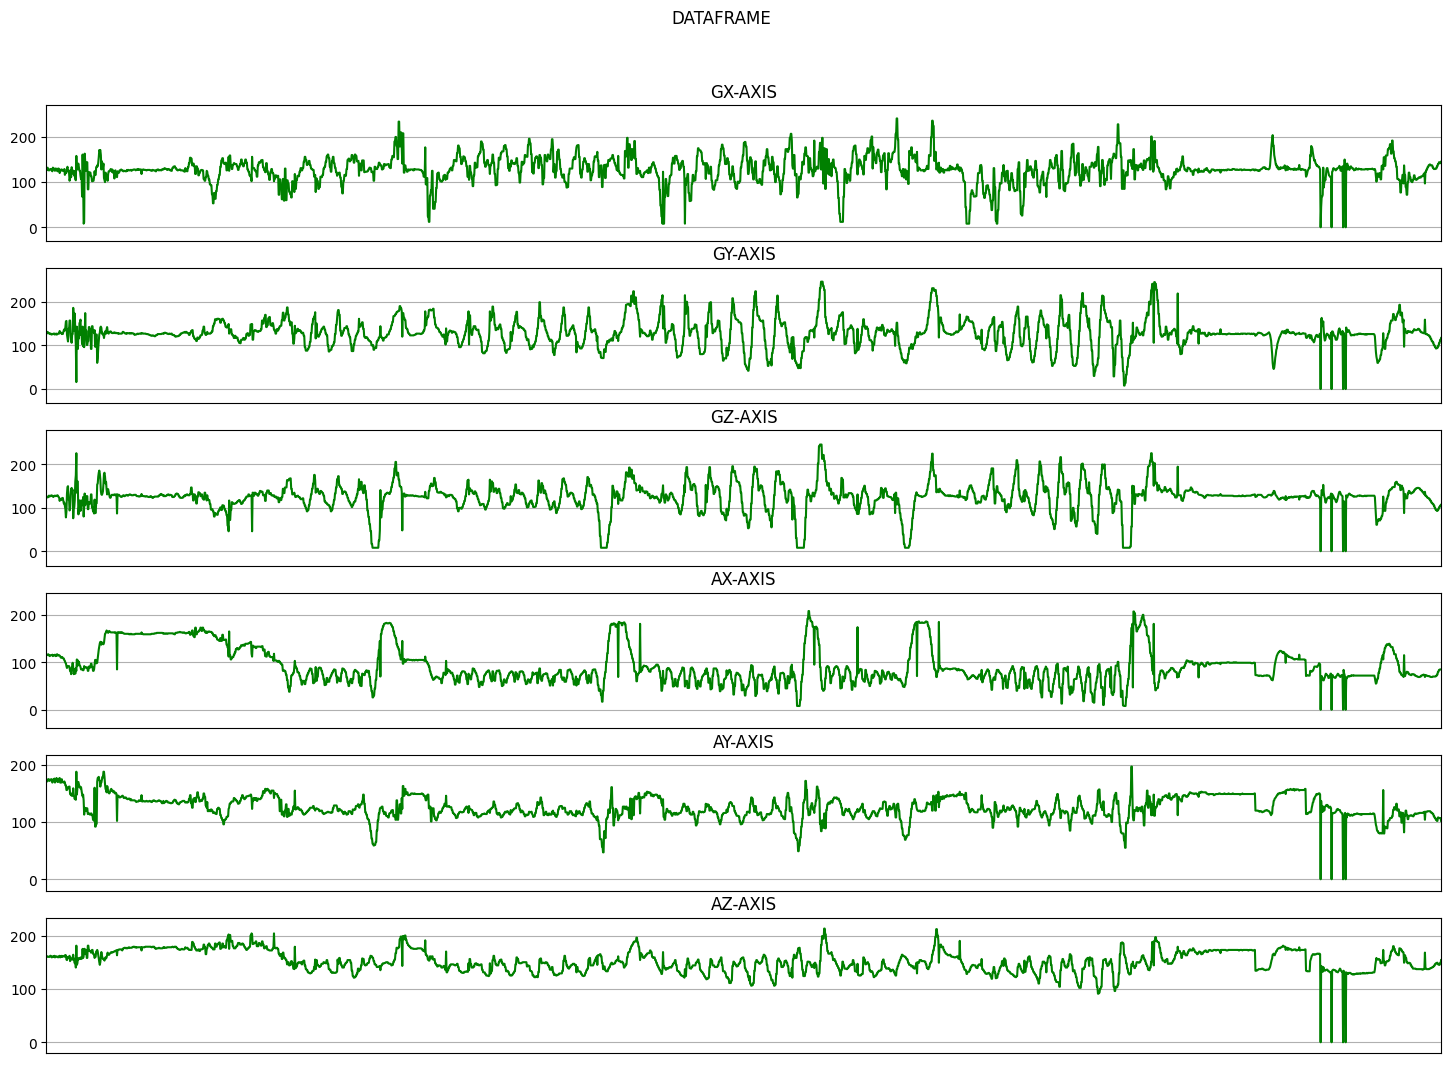

In [11]:
plot_full_v2(df_copy)

# Visualise Data

In [12]:
Fs=20
activities = df['Activity_code'].value_counts().index
activities

KeyError: 'Activity_code'

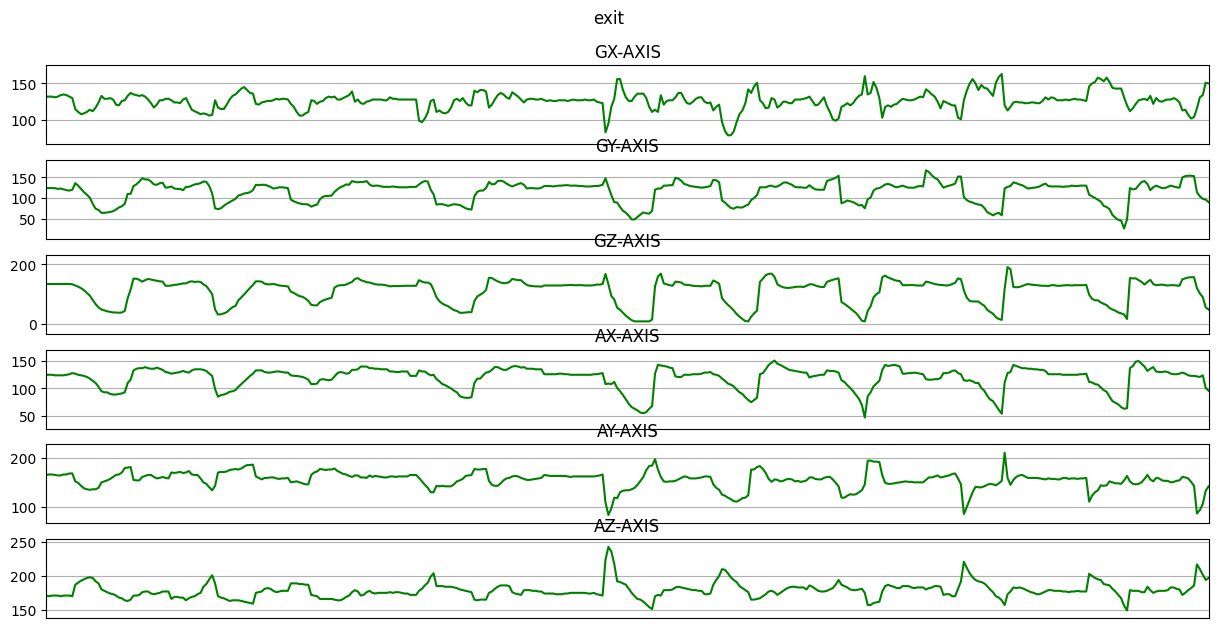

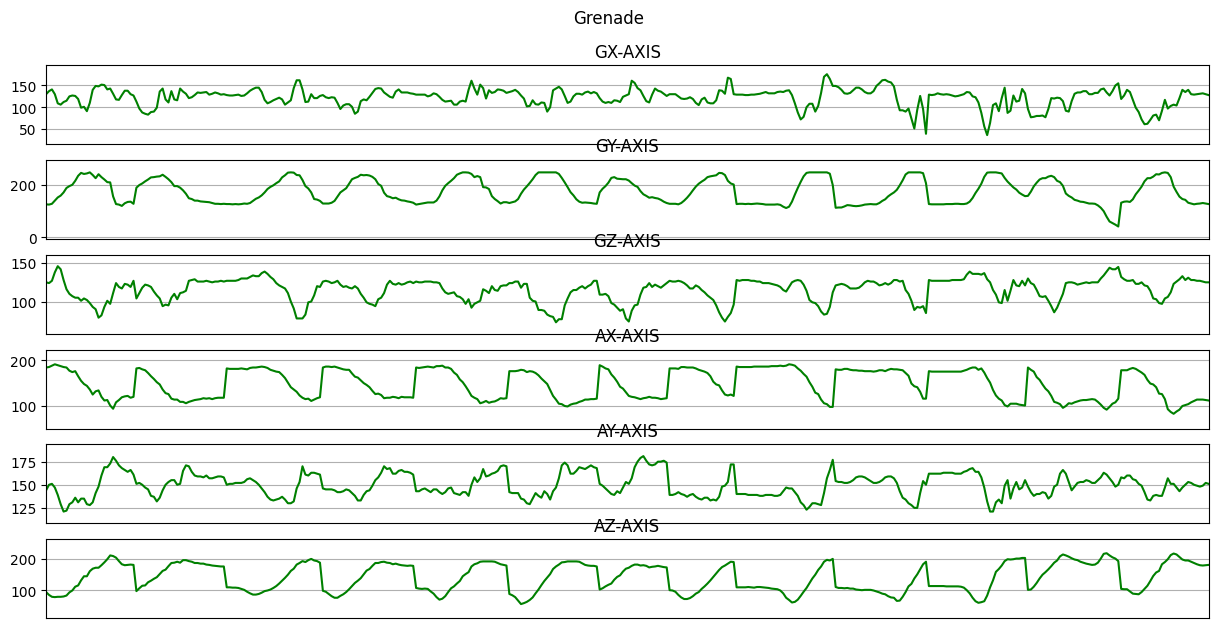

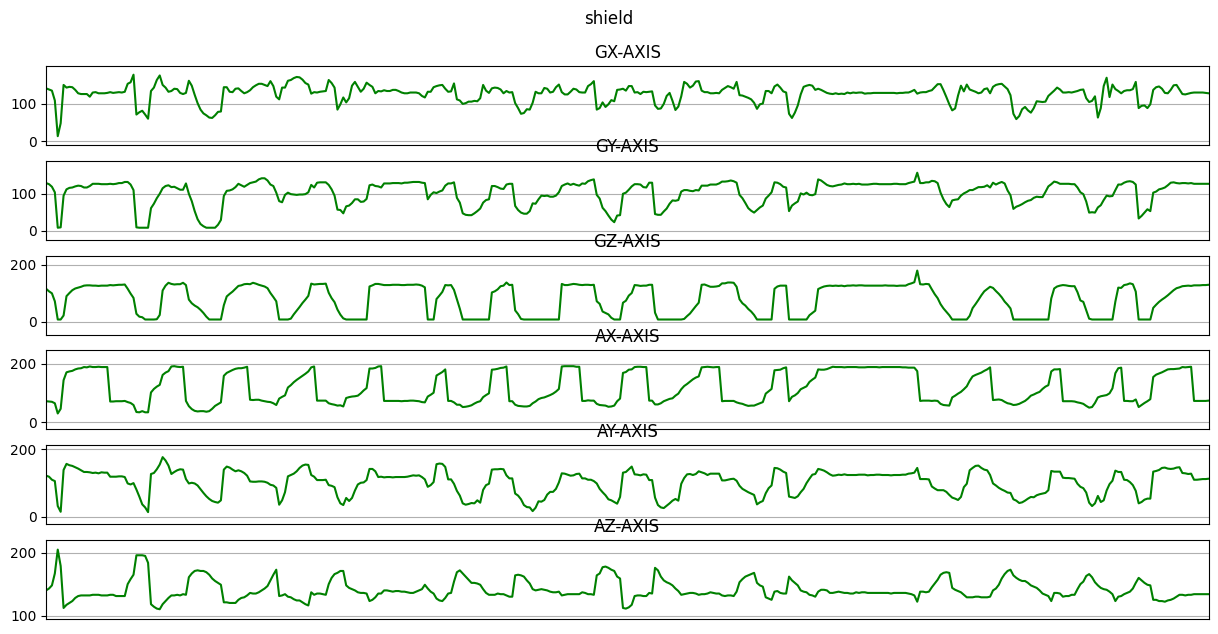

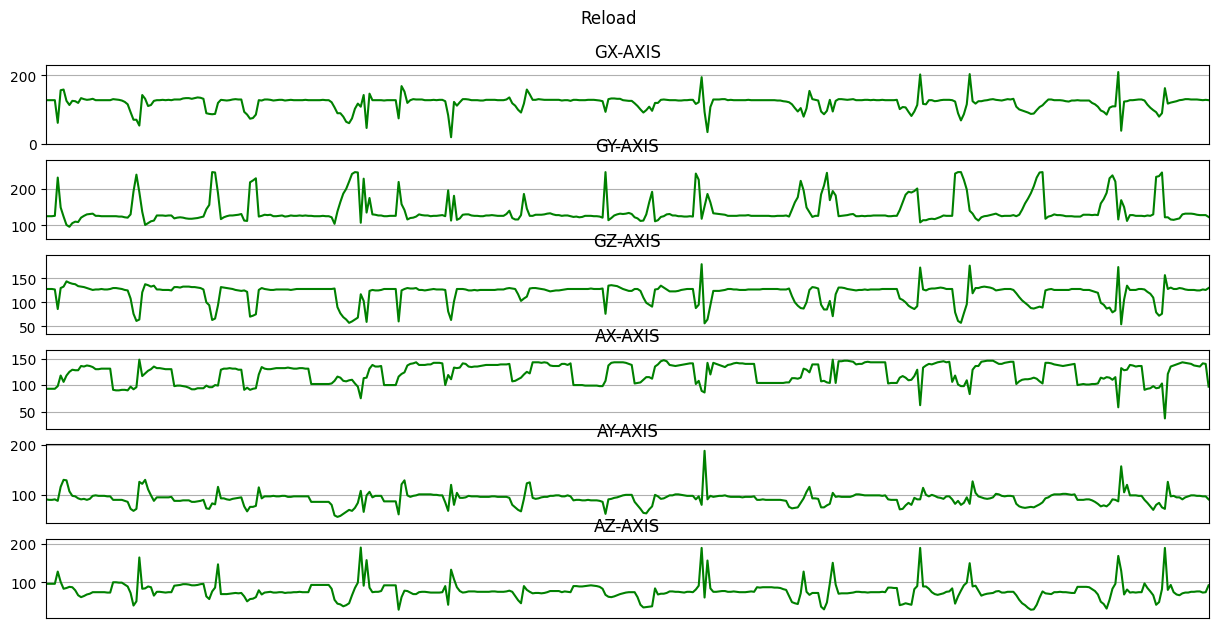

In [27]:
filt_df = df
for activity in activities:
    data_for_plot = filt_df[(filt_df['Activity_code'] == activity)][:Fs*20]
    plot_activity_v2(activity, data_for_plot)


In [22]:
# filt_df = filt_df.drop('Subject_id', axis=1)
filt_df = filt_df.drop('time', axis=1)

In [14]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from modelling_utils import encode, scale_255, scale_vals, scaled_data, get_frames

In [15]:
df_copy, label = encode(df_copy)

print(label.classes_)
df_copy.head()

,Activity_code,ax,ay,az,gx,gy,gz,time,label
0,shield,72,122,140,140,129,116,1,3
1,shield,71,119,143,137,126,107,2,3
2,shield,70,110,148,134,119,100,3,3
3,shield,65,106,167,108,104,72,4,3
4,shield,30,32,205,14,8,8,5,3


In [20]:
data = scale_vals(df_copy)

In [21]:
# ds_X = data[['ax','ay','az','gx','gy','gz']]
# # ds_Y = data['label']
# scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
# # scaled_X['Activity_code'] = ds_Y.values
scaled_X = scaled_data(data, labelled=False)

,ax,ay,az,gx,gy,gz
0,0.458824,0.678431,0.631373,0.494118,0.498039,0.498039
1,0.450980,0.670588,0.627451,0.494118,0.498039,0.494118
2,0.450980,0.670588,0.631373,0.505882,0.501961,0.490196
3,0.454902,0.682353,0.631373,0.517647,0.513725,0.486275
4,0.458824,0.686275,0.627451,0.498039,0.505882,0.490196
...,...,...,...,...,...,...
2671,0.329412,0.419608,0.568627,0.564706,0.411765,0.396078
2672,0.329412,0.419608,0.568627,0.564706,0.411765,0.396078
2673,0.333333,0.419608,0.580392,0.556863,0.439216,0.411765
2674,0.333333,0.419608,0.580392,0.556863,0.439216,0.411765


In [20]:
import scipy.stats as stats

In [24]:
seconds = 1
Fs = 20
frame_size = Fs*seconds # 20Hz * 1 = 20
hop_size = Fs*seconds

In [27]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=False)

In [28]:
x.shape, y.shape

(133, 20, 6)

In [35]:
BUFFER_SIZE=x.shape[0]
BATCH_SIZE=64

# Turn numpy arrays into tf dataset
ds = tf.data.Dataset.from_tensor_slices(x)
# Cache te dataset
ds = ds.cache()
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE)
# Reduce likelihood of bottlenecking
ds = ds.prefetch(int(BATCH_SIZE/2))

ds.as_numpy_iterator().next().shape

(64, 20, 6)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [27]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((99, 20, 6), (25, 20, 6), (99,), (25,))

In [24]:
# For conv2D

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# X_train.shape, X_test.shape


((15385, 20, 6, 1), (3847, 20, 6, 1))

### MODEL BUILD

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam


In [29]:
model = Sequential()
model.add(Conv1D(8, 3, activation='relu', input_shape = X_train[0].shape))
model.add(Dropout(0.2))

model.add(Conv1D(16, 4, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [30]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             152       
                                                                 
 dropout (Dropout)           (None, 18, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 24)                5784      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0

In [31]:
history = model.fit(X_train, Y_train, epochs=1000, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/1000


2022-10-03 18:44:24.495104: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 1s 41ms/step - loss: 1.3596 - accuracy: 0.3535 - val_loss: 1.3302 - val_accuracy: 0.5600
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.3878 - accuracy: 0.2222 - val_loss: 1.3098 - val_accuracy: 0.5600
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.3960 - accuracy: 0.2626 - val_loss: 1.2952 - val_accuracy: 0.5600
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.3791 - accuracy: 0.2929 - val_loss: 1.2810 - val_accuracy: 0.5600
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.3558 - accuracy: 0.3131 - val_loss: 1.2685 - val_accuracy: 0.5600
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.4133 - accuracy: 0.3030 - val_loss: 1.2582 - val_accuracy: 0.5600
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 1.3997 - accuracy: 0.2828 - val_loss: 1.2475 - val_accuracy: 0.5600
Epoch 8/1000
4/4 [==============

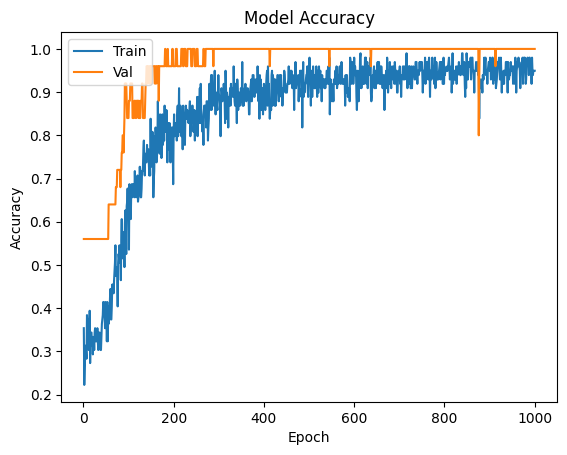

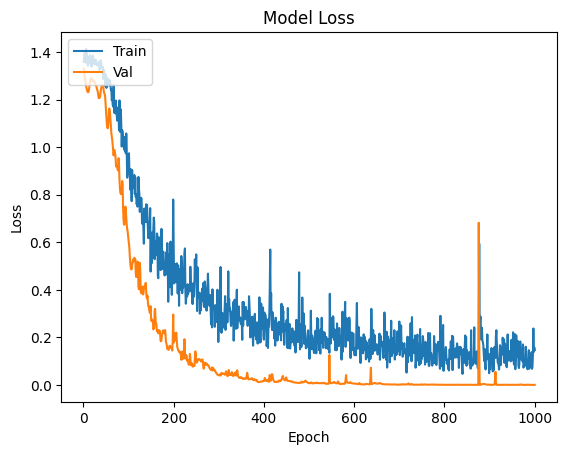

In [32]:
plot_history(history, 1000)

# Confusion Matrix

In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [57]:
y_pred = model.predict(x)
classes_y = np.argmax(y_pred,axis=1)
chances = np.array([y_pred[i][np.argmax(y_pred[i])] for i in range(y_pred.shape[0])])

for i in range(chances.shape[0]):
    if chances[i] < 0.95:
        print(0, end=" ")
    else:
        print(classes_y[i], end=" ")

5/5 [==============================] - 0s 697us/step
2 2 2 2 3 2 2 2 2 2 0 0 0 0 2 0 0 0 2 2 2 2 0 0 3 0 3 3 0 3 3 3 3 0 2 2 0 0 0 3 0 3 3 3 3 0 3 0 3 3 3 3 3 3 3 3 0 2 2 1 3 1 3 0 3 3 0 0 1 3 1 3 3 0 1 2 0 3 3 3 0 3 3 3 3 0 2 2 0 0 1 0 3 1 3 1 3 1 3 1 3 1 0 3 3 0 0 2 2 2 2 2 2 2 2 2 3 0 2 2 2 2 3 0 0 0 0 3 3 0 0 0 3 

In [31]:
print(classes_y)

[2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 0 0 3 2 2 2 2 0 1 3 3 3 3 1 3 3 3 3 3 2 2 0
 1 2 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 0 2 2 1 3 1 3 3 3 3 3 3 1 3 1 3 3 3
 1 2 1 3 3 3 3 3 3 3 3 0 2 2 0 3 1 3 3 1 3 1 3 1 3 1 3 1 3 3 3 3 0 2 2 2 2
 2 2 2 2 2 3 3 2 2 2 2 3 3 1 3 3 3 3 0 3 1 3]


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

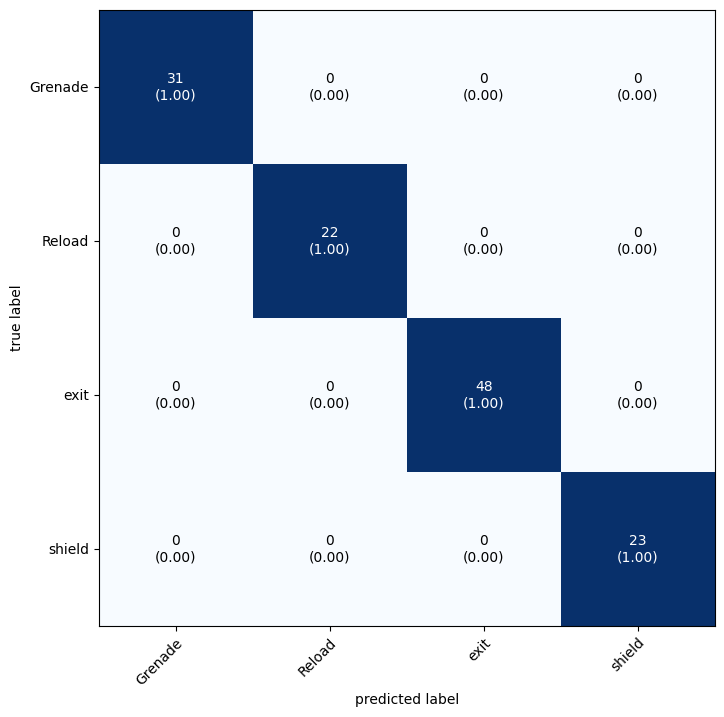

In [46]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


# Save Model

In [36]:
model_name = 'model_cnn_real_0'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model.save(MODEL_DIR)


# Load Model

In [16]:
model_name = 'model_cnn_real_0'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             152       
                                                                 
 dropout (Dropout)           (None, 18, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 24)                5784      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0

In [62]:
w_0 = model.layers[0].get_weights()[0]
b_0 = model.layers[0].get_weights()[1]
w_1 = model.layers[2].get_weights()[0]
b_1 = model.layers[2].get_weights()[1]
w_2 = model.layers[5].get_weights()[0]
b_2 = model.layers[5].get_weights()[1]
w_3 = model.layers[7].get_weights()[0]
b_3 = model.layers[7].get_weights()[1]

final_w = model.layers[9].get_weights()[0]
final_b = model.layers[9].get_weights()[1]


In [63]:
# layers = np.array([conv2d_w_0,conv2d_b_0,conv2d_w_1,conv2d_b_1,dense_w_0,dense_b_0,dense_w_1,dense_b_1])

layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])

for i in layers:
    print(i.shape)

(3, 6, 8)
(8,)
(4, 8, 16)
(16,)
(240, 24)
(24,)
(24, 12)
(12,)
(12, 4)
(4,)


/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_89833/4147205472.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])


In [64]:
y_pred = model.predict(X_test[0:20])
classes_y = np.argmax(y_pred,axis=1)
classes_y

1/1 [==============================] - 0s 9ms/step


array([0, 0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 3])

In [65]:
Y_test[0:20]

array([0, 0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 3])

# Save Numpy

In [66]:
# outpath = paths.get('WEIGHT_DIR')
outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv_layers_real')
# SAVE NP
save_np = layers

np.save(outpath, save_np)

In [67]:
dataframe = np.array([X_train, X_test, Y_train, Y_test])

outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv_df_real')

np.save(outpath, dataframe)

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_89833/2982726952.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataframe = np.array([X_train, X_test, Y_train, Y_test])


In [66]:
viz = layers[1]

print(viz)
print(viz.shape)

[ 0.9982494   0.6770703  -0.06876229  0.3487218  -0.01582066  0.
  0.         -0.00355527 -0.20330736 -0.31644577  0.         -0.08707343
  0.          0.         -0.32662997  0.         -0.07762001  0.
 -0.0094172   0.7266123  -0.30941087 -0.52208877 -0.01606345 -0.05250494]
(24,)


In [441]:
def ReLu(x):
    return np.maximum(0,x)

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def ori_kernel_mult(in_dps, kernels):
    # Num of filters (24)
    r = np.empty([in_dps.shape[0]-kernels.shape[0]+1, kernels.shape[2]])
    for j in range(0,kernels.shape[2]):
        # Num of output (shape[0]) > (18)
        out = np.zeros(in_dps.shape[0]-kernels.shape[0]+1)
        for i in range(0, in_dps.shape[0]-kernels.shape[0]+1):
            # Iterate kernel size sum > (3)
            sum = 0
            for k in range(0,kernels.shape[0]):
                # Iterate through prev filters / channels (6) 
                for f in range(0, kernels.shape[1]):
                    sum += kernels[k][f][j]*in_dps[i+k][f]
            r[i][j]=sum
    return r

def convolute(in_dps, kernels, k, stride,a):
    # print(stride, a)
    conv_p=0
    conv_kernels=np.zeros(kernels.shape[0]*kernels.shape[1]*kernels.shape[2])
    conv_kernels = conv_kernels.reshape(kernels.shape[0],kernels.shape[1],kernels.shape[2])
    in_int=in_dps[int(stride*kernels.shape[1]):int(stride*kernels.shape[1]+kernels.shape[1]*kernels.shape[0])]
    # print(in_int)
    for i in range(kernels.shape[1]):
        for j in range(kernels.shape[0]):
            conv_kernels[j][i][k]=kernels[j][i][k]
    for i in range(kernels.shape[1]):
        for j in range(kernels.shape[0]):
            idx = j*kernels.shape[1]+i
            # print(idx, i, j, k)
            conv_p += in_int[idx]*conv_kernels[j][i][k]
    out = conv_p
    return out

def kernel_mult(in_dps,kernels, biases, a):
    p = 1
    filters=kernels.shape[1]
    for i in in_dps.shape:
        p = p * i
    in_dps = in_dps.reshape(p)
    output=np.zeros((a-kernels.shape[0]+1)*kernels.shape[2])
    print(a-kernels.shape[0]+1)
    for i in range(kernels.shape[2]):
        for j in range(a-kernels.shape[0]+1):
            val = convolute(in_dps,kernels,i,j,a-kernels.shape[0]+1)
            output[j*kernels.shape[2]+i] = val + biases[i]
    return output


def kernel_add(in_dps, biases):
    for b in range(0,biases.shape[0]):
        for i in range(0,in_dps.shape[0]):
            in_dps[i][b] += biases[b]
    return in_dps

def self_add(in_dps, biases):
    for i in range(in_dps.shape[0]):
        in_dps[i]+=biases[i]
    return in_dps

In [459]:
# dense_test = X_test[0].reshape(120)
dense_test = X_test[1]
mult = kernel_mult(dense_test, layers[0], layers[1], 20)
# mult = ori_kernel_mult(dense_test, layers[0])
# mult = kernel_add(mult, layers[1])
mult = ReLu(mult)
mult = kernel_mult(mult, layers[2], layers[3], 18)
# mult = ori_kernel_mult(mult, layers[2])
# mult = kernel_add(mult, layers[3])
mult = ReLu(mult)
# mult = mult.reshape(720)
mult = np.dot(mult, layers[4])
mult = self_add(mult, layers[5])
mult = ReLu(mult)
mult = np.dot(mult, layers[6])
mult = self_add(mult, layers[7])
mult = ReLu(mult)
mult = np.dot(mult, layers[8])
mult = self_add(mult, layers[9])
mult = ReLu(mult)

# mult = softmax(mult)
print(mult.shape)
print(mult)

18
15
(4,)
[0.         0.91876486 0.         4.43290832]


In [38]:
intermediate_layers = model.layers[:10]
intermediate_model = Sequential(intermediate_layers)
intermediate_model.build(input_shape=(None,20,6,1))
intermediate_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             152       
                                                                 
 dropout (Dropout)           (None, 18, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 24)                5784      
                                                                 
 dropout_2 (Dropout)         (None, 24)               

In [39]:
yhat = intermediate_model.predict(X_test[0:25])

1/1 [==============================] - 0s 49ms/step


In [40]:
viz = yhat[0]
print(viz.shape)
print(viz)

(4,)
[9.9864537e-01 8.3152440e-07 4.1502778e-04 9.3872799e-04]


# Print Layers in Cpp

In [68]:
def printCpp(layer):
    wrap = layer.ndim
    if (wrap > 1):
        for i in range(len(layer)):
            print("{", end="")
            printCpp(layer[i])
            if i==len(layer)-1:
                print("}", end="")
            else:
                print("},", end=" \n")
    else:
        for i in range(len(layer)):
            if (i==(len(layer)-1)):
                print(layer[i],end="")
            else:
                print(layer[i],end=", ")


In [99]:
# i-=2
# toPrint = X_test[5:7].reshape(2,120)
# toPrint = Y_test[5:7]
toPrint = layers[8]

print("{", end="")
printCpp(toPrint)
print("};", end="\n")

{{-0.8757577, 0.05912632, 0.09932468, 0.21477053}, 
{0.0044303224, -0.038006492, -0.56587, -0.6866429}, 
{0.48046982, -0.52184236, 0.6048948, -0.6842622}, 
{0.07132181, -0.7183946, 0.11059915, -0.8024339}, 
{-0.5945972, 0.11449261, 0.31713483, -0.71885407}, 
{-0.17392, 0.2358421, -0.77541965, -1.0309747}, 
{-0.28213137, -1.8996767, -0.12002885, -0.26996583}, 
{-0.05378228, -0.95066804, 0.18506777, -0.7818162}, 
{-1.0283866, 0.28525448, -0.72799784, 0.3726984}, 
{0.53684545, 0.5932937, -0.2519535, -0.85684574}, 
{0.44448435, 0.5649827, -0.653739, -0.85743123}, 
{-0.36113086, -0.0109125655, -0.33740416, 0.88281304}};
